<a href="https://colab.research.google.com/github/anilbhatt1/EVA4P1_S15B_Colab_Notebook_Versions/blob/master/EVA4P1_S15_Understanding_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Sun May 31 16:42:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import seaborn as sns
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
sns.set()

#import albumentations
#print(albumentations.__version__) # check version

# This is to install and use albumentations latest package v0.4.5
#album_version_needed = "0.4.5"
#if albumentations.__version__ != album_version_needed:
#  !pip install albumentations==0.4.5   # 0.4.5 is the latest albumentation version
print('Pytorch version:', torch.__version__)

!pip install kornia
from kornia.losses import SSIM
from kornia.losses import DiceLoss

Pytorch version: 1.5.0+cu101
     |████████████████████████████████| 163kB 2.8MB/s 


### Statistics of FG_BG Images

In [4]:
FG_BG_zip =  ZipFile("/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_400K.zip", 'r')
all_files = [info.filename for info in FG_BG_zip.infolist() if not info.is_dir()]

n = 0
s = np.zeros(3)
sq = np.zeros(3)
for img_file in all_files[0:]:
    if img_file.endswith('jpg'):
        imgdata = FG_BG_zip.read(img_file)
        data = Image.open(io.BytesIO(imgdata))
        x = np.array(data)/255
        s += x.sum(axis=(0,1))
        sq += np.sum(np.square(x),axis=(0,1))
        n += x.shape[0]*x.shape[1]
mu = s/n
std =np.sqrt((sq/n - np.square(mu)))
print(mu,sq/n,std,n)

[0.56670278 0.49779153 0.43632878] [0.38389994 0.30871084 0.25551239] [0.25049532 0.2468085  0.25520498] 14745600000


### Statistics of FG_BG_Mask Images

In [5]:
FG_BG_Mask_zip =  ZipFile("/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Mask_400K.zip", 'r')
all_files = [info.filename for info in FG_BG_Mask_zip.infolist() if not info.is_dir()]
n = 0
s = np.zeros(1)
sq = np.zeros(1)
for img_file in all_files[0:]:
    if img_file.endswith('jpg'):
        imgdata = FG_BG_Mask_zip.read(img_file)
        data = Image.open(io.BytesIO(imgdata))
        x = np.array(data)/255
        s += x.sum(axis=(0,1))
        sq += np.sum(np.square(x),axis=(0,1))
        n += x.shape[0]*x.shape[1]
mu = s/n
std =np.sqrt((sq/n - np.square(mu)))
print(mu,sq/n,std,n)

[0.20249742] [0.20069515] [0.39961225] 14745600000


### Statistics of FG_BG_Depth Images

In [6]:
FG_BG_Depth_zip =  ZipFile("/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Depth_400K.zip", 'r')
all_files = [info.filename for info in FG_BG_Depth_zip.infolist() if not info.is_dir()]
n = 0
s = np.zeros(1)
sq = np.zeros(1)
for img_file in all_files[0:]:
    if img_file.endswith('jpg'):
        imgdata = FG_BG_Depth_zip.read(img_file)
        data = Image.open(io.BytesIO(imgdata))
        x = np.array(data)/255
        s += x.sum(axis=(0,1))
        sq += np.sum(np.square(x),axis=(0,1))
        n += x.shape[0]*x.shape[1]
mu = s/n
std =np.sqrt((sq/n - np.square(mu)))
print(mu,sq/n,std,n)

[0.32939295] [0.17065376] [0.24930712] 16000000000


### Statistics of BG and its Flip Images

In [0]:
path = '/content/BG_and_Its_Flip/'
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for img_file in os.listdir('/content/BG_and_Its_Flip/'):
    if img_file.endswith('jpg'):
        data = Image.open(f'{path}{img_file}')
        print(type(data))
        x = np.array(data)/255
        print(x.shape)
        s += x.sum(axis=(0,1))
        sq += np.sum(np.square(x),axis=(0,1))
        n += x.shape[0]*x.shape[1]
mu = s/n
std =np.sqrt((sq/n - np.square(mu)))
print(mu,sq/n,std,n)

### Unzip FG_BG, Mask, Depth and corresponding BG images from gdrive

In [4]:
t1 = time()
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Mask_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Depth_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/BG_and_Its_Flip.zip"
t2 = time()
print(f'FG_BG, Mask & Depth Copy took {(t2-t1)/60:.5f} minutes')

FG_BG, Mask & Depth Copy took 5.74263 minutes


### Copying Log file that contains FG_BG file names, their path in gdrive & corresponding BG file name from which they were made 

In [5]:
if os.path.exists('/content/FG_BG_Filename_withflip_Logs.txt'):
    print('Log file exists')    
else:  
    !cp '/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Filename_withflip_Logs.txt' '/content/'
    print('Copied Log File')

Copied Log File


### Copying SRC libraries from Github to Colab.

In [6]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/EVA4P1_S15B_Depth_FG_Detection

Cloning into 'EVA4P1_S15B_Depth_FG_Detection'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 435 (delta 62), reused 0 (delta 0), pack-reused 307
Receiving objects: 100% (435/435), 14.90 MiB | 7.47 MiB/s, done.
Resolving deltas: 100% (205/205), done.


In [7]:
%cd '/content/EVA4P1_S15B_Depth_FG_Detection/src'
! ls

/content/EVA4P1_S15B_Depth_FG_Detection/src
dataset  __init__.py  losses  models  utils


### Importing modules from Colab data folder to Colab session 

In [0]:
os.chdir('/content/EVA4P1_S15B_Depth_FG_Detection/')
import src
from src.dataset import datatransforms as dtf
from src.dataset import makedata as md
from src.dataset import make1data as md1
from src.dataset import Alb_data_transforms as Alb
from src.models  import S15_FGDepth_models as ntwk
from src.losses  import Train as Train
from src.losses  import Test  as Test
from src.losses  import Train1 as Train1
from src.losses  import Test1  as Test1
from src.utils   import Freeze_Layers as Freeze

### Creating a list - content_list for FG_BG log file. This content_list will be used to create dataloader to pick-up input images randomly for both training and testing

In [9]:
log_fg_bg = open('/content/FG_BG_Filename_withflip_Logs.txt',"r")
content_list = log_fg_bg.readlines()
print('No: of records in log_fg_bg:',len(content_list))
print(content_list[0])
log_fg_bg.close()

data_root = Path('/content')
f1, f2, f3, f4 = data_root/'FG_BG_400K', data_root/'BG_and_Its_Flip', data_root/'FG_BG_Mask_400K',  \
                 data_root/'FG_BG_Depth_0_400K'

No: of records in log_fg_bg: 400000
Img_fg_bg_1.jpg,Img21.jpg,Image41.png,(192, 192, 108, 156, 51, 3, 159, 3, 51, 159, 159, 159)



In [0]:
bs_small   = 96
bs_medium = 96
bs_large  = 16
bs_test   = 96
rows = 5
img_save, model_save = 1500, 500
t0k, t10k, t80k, t160k, t220k, t260k, t280k, t360k, t390k, t400k  = 0, 10000, 80000, 160000, 220000,\
                                                                             260000, 280000, 360000,\
                                                                                     390000, 400000

### Creating tranforms. For test transform only 'To Tensor' is used.

In [0]:
import albumentations as A
lst = [(64,64),(96,96),(192,192)]
#fg_bg_mean, fg_bg_stdev                    = [0.56670278, 0.49779153, 0.43632878], [0.25049532, 0.2468085, 0.25520498]
#mask_mean,  mask_stdev                     = [0.20249742], [0.39961225]
#depth_mean, depth_stdev                    = [0.32939295], [0.24930712]
#bg_mean, bg_stdev                          = [0.58245822, 0.51269352, 0.43691653], [0.24252189, 0.24318804, 0.25401604]
fg_bg_mean, fg_bg_stdev                    = [144.5, 126.9, 111.26], [63.88, 62.94, 65.08]
mask_mean,  mask_stdev                     = [51.6], [101.9]
depth_mean, depth_stdev                    = [83.995], [63.57]
bg_mean, bg_stdev                          = [148.53, 130.74, 111.41], [61.84, 62.01, 64.77]
fg_bg_transforms, bg_transforms, mask_transforms, depth_transforms = {}, {}, {}, {}
test_fg_bg_transforms, test_bg_transforms                          = {}, {}
for i in range(len(lst)):
    ht, wd = lst[i]
    cut_out_size = int(ht/4)
    fg_bg_transforms["t_{0}".format(i)] = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                     #A.IAAAdditiveGaussianNoise(),
                                                                     #A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                     A.Normalize(mean=fg_bg_mean, std=fg_bg_stdev),
                                                                     A.Cutout(num_holes=1,max_h_size=cut_out_size,max_w_size=cut_out_size),])
    bg_transforms["t_{0}".format(i)]       = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                     #A.IAAAdditiveGaussianNoise(),
                                                                     #A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                     A.Normalize(mean=bg_mean, std=bg_stdev),])
    mask_transforms["t_{0}".format(i)]     = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                     A.Normalize(mean=mask_mean, std=mask_stdev),])
    depth_transforms["t_{0}".format(i)]    = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                     A.Normalize(mean=depth_mean, std=depth_stdev),])
    test_fg_bg_transforms["t_{0}" .format(i)]  = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                              A.Normalize(mean=fg_bg_mean, std=fg_bg_stdev),])
    test_bg_transforms["t_{0}" .format(i)]        = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                              A.Normalize(mean=bg_mean, std=bg_stdev),])   

In [0]:
fg_bg_transforms1, bg_transforms1, mask_transforms1, depth_transforms1 = {}, {}, {}, {}
test_fg_bg_transforms1, test_bg_transforms1                            = {}, {}
for i in range(len(lst)):
    ht, wd = lst[i]
    cut_out_size = int(ht/4)    
    fg_bg_transforms1["t_{0}".format(i)] = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),])
                                                                     #A.IAAAdditiveGaussianNoise(),
                                                                     #A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                     #A.Normalize(mean=fg_bg_mean, std=fg_bg_stdev), 
    bg_transforms1["t_{0}".format(i)]       = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),])
                                                                     #A.IAAAdditiveGaussianNoise(),
                                                                     #A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                     #A.Normalize(mean=bg_mean, std=bg_stdev),])
    mask_transforms1["t_{0}".format(i)]     = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),])
                                                                     #A.Normalize(mean=mask_mean, std=mask_stdev),])
    depth_transforms1["t_{0}".format(i)]    = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),])
                                                                     #A.Normalize(mean=depth_mean, std=depth_stdev),])
    test_fg_bg_transforms1["t_{0}" .format(i)]  = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),])
                                                                              #A.Normalize(mean=fg_bg_mean, std=fg_bg_stdev),])    
    test_bg_transforms1["t_{0}" .format(i)]        = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),])
                                                                              #A.Normalize(mean=bg_mean, std=bg_stdev),])                                                                        

In [13]:
print(fg_bg_transforms1)
print(bg_transforms1)
print(mask_transforms1)
print(depth_transforms1)
print(test_fg_bg_transforms1)
print(test_bg_transforms1)

{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f8b00f9b048>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f8b00f9b6d8>, 't_2': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f8b00f9bd68>}
{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f8b00f9b160>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f8b00f9b7f0>, 't_2': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f8b00f9be80>}
{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f8b00f9b278>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f8b00f9b908>, 't_2': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f8b00f9bf98>}
{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f8b00f9b390>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0

In [0]:
train_ds_mini_1    = md1.Make1data(f1, content_list, 0, 10,  
                             fg_bg_transforms['t_0'],bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
train_ds_mini_2    = md1.Make1data(f1, content_list, 0, 10,  
                             fg_bg_transforms['t_0'],bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
train_ds_mini_3    = md1.Make1data(f1, content_list, 0, 10,  
                             fg_bg_transforms['t_0'],bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
train_ds_medium    = md1.Make1data(f1, content_list, 0, 10,  
                             fg_bg_transforms['t_1'],bg_transforms['t_1'],mask_transforms['t_1'],depth_transforms['t_1'])
train_ds_large   = md1.Make1data(f1, content_list, 0, 10,  
                             fg_bg_transforms['t_2'],bg_transforms['t_2'],mask_transforms['t_2'],depth_transforms['t_2'])
test_ds          = md1.Make1data(f1, content_list, 0, 10,  
                             test_fg_bg_transforms['t_0'],test_bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])

In [0]:
train_ds_mini_11    = md1.Make1data(f1, content_list, 0, 10,  
                             fg_bg_transforms1['t_0'],bg_transforms1['t_0'],mask_transforms1['t_0'],depth_transforms1['t_0'])
train_ds_mini_21    = md1.Make1data(f1, content_list, 0, 10,  
                             fg_bg_transforms1['t_0'],bg_transforms1['t_0'],mask_transforms1['t_0'],depth_transforms1['t_0'])
train_ds_mini_31    = md1.Make1data(f1, content_list, 0, 10,  
                             fg_bg_transforms1['t_0'],bg_transforms1['t_0'],mask_transforms1['t_0'],depth_transforms1['t_0'])
train_ds_medium1    = md1.Make1data(f1, content_list, 0, 10,  
                             fg_bg_transforms1['t_1'],bg_transforms1['t_1'],mask_transforms1['t_1'],depth_transforms1['t_1'])
train_ds_large1   = md1.Make1data(f1, content_list, 0, 10,  
                             fg_bg_transforms1['t_2'],bg_transforms1['t_2'],mask_transforms1['t_2'],depth_transforms1['t_2'])
test_ds1          = md1.Make1data(f1, content_list, 0, 10,  
                             test_fg_bg_transforms1['t_0'],test_bg_transforms1['t_0'],mask_transforms1['t_0'],depth_transforms1['t_0'])

In [0]:
train_dl_mini_1  = DataLoader(train_ds_mini_1, batch_size = bs_small,shuffle = True, pin_memory = True)
train_dl_mini_2  = DataLoader(train_ds_mini_2, batch_size = bs_small,shuffle = True, pin_memory = True)
train_dl_mini_3  = DataLoader(train_ds_mini_3, batch_size = bs_small, shuffle = True, pin_memory = True)
train_dl_medium  = DataLoader(train_ds_medium, batch_size = bs_medium, shuffle = True, pin_memory = True)
train_dl_large  = DataLoader(train_ds_large, batch_size = bs_large, shuffle = True, pin_memory = True)
test_dl         = DataLoader(test_ds,     batch_size = bs_test,       shuffle = True, pin_memory = True)

In [0]:
train_dl_mini_11  = DataLoader(train_ds_mini_11, batch_size = bs_small,shuffle = True, pin_memory = True)
train_dl_mini_21  = DataLoader(train_ds_mini_21, batch_size = bs_small,shuffle = True, pin_memory = True)
train_dl_mini_31  = DataLoader(train_ds_mini_31, batch_size = bs_small, shuffle = True, pin_memory = True)
train_dl_medium1  = DataLoader(train_ds_medium1, batch_size = bs_medium, shuffle = True, pin_memory = True)
train_dl_large1  = DataLoader(train_ds_large1, batch_size = bs_large, shuffle = True, pin_memory = True)
test_dl1         = DataLoader(test_ds1,     batch_size = bs_test,       shuffle = True, pin_memory = True)

In [0]:
images_mini_1 = next(iter(train_dl_mini_1))
images_mini_2 = next(iter(train_dl_mini_2))
images_mini_3 = next(iter(train_dl_mini_3))
images_medium = next(iter(train_dl_medium))
images_large  = next(iter(train_dl_large))
images_test   = next(iter(test_dl))

In [0]:
images_mini_11 = next(iter(train_dl_mini_11))
images_mini_21 = next(iter(train_dl_mini_21))
images_mini_31 = next(iter(train_dl_mini_31))
images_medium1 = next(iter(train_dl_medium1))
images_large1  = next(iter(train_dl_large1))
images_test1   = next(iter(test_dl1))

In [20]:
print('B1:',[(k, v.shape) for k, v in images_mini_1.items()])
print('B2:',[(k, v.shape) for k, v in images_mini_2.items()])
print('B3:',[(k, v.shape) for k, v in images_mini_3.items()])
print('B4:',[(k, v.shape) for k, v in images_medium.items()])
print('B5:',[(k, v.shape) for k, v in images_large.items()])
print('B6:',[(k, v.shape) for k, v in images_test.items()])

B1: [('f1', torch.Size([10, 3, 64, 64])), ('f2', torch.Size([10, 3, 64, 64])), ('f3', torch.Size([10, 1, 64, 64])), ('f4', torch.Size([10, 1, 64, 64]))]
B2: [('f1', torch.Size([10, 3, 64, 64])), ('f2', torch.Size([10, 3, 64, 64])), ('f3', torch.Size([10, 1, 64, 64])), ('f4', torch.Size([10, 1, 64, 64]))]
B3: [('f1', torch.Size([10, 3, 64, 64])), ('f2', torch.Size([10, 3, 64, 64])), ('f3', torch.Size([10, 1, 64, 64])), ('f4', torch.Size([10, 1, 64, 64]))]
B4: [('f1', torch.Size([10, 3, 96, 96])), ('f2', torch.Size([10, 3, 96, 96])), ('f3', torch.Size([10, 1, 96, 96])), ('f4', torch.Size([10, 1, 96, 96]))]
B5: [('f1', torch.Size([10, 3, 192, 192])), ('f2', torch.Size([10, 3, 192, 192])), ('f3', torch.Size([10, 1, 192, 192])), ('f4', torch.Size([10, 1, 192, 192]))]
B6: [('f1', torch.Size([10, 3, 64, 64])), ('f2', torch.Size([10, 3, 64, 64])), ('f3', torch.Size([10, 1, 64, 64])), ('f4', torch.Size([10, 1, 64, 64]))]


In [21]:
print('B1:',[(k, v.shape) for k, v in images_mini_11.items()])
print('B2:',[(k, v.shape) for k, v in images_mini_21.items()])
print('B3:',[(k, v.shape) for k, v in images_mini_31.items()])
print('B4:',[(k, v.shape) for k, v in images_medium1.items()])
print('B5:',[(k, v.shape) for k, v in images_large1.items()])
print('B6:',[(k, v.shape) for k, v in images_test1.items()])

B1: [('f1', torch.Size([10, 3, 64, 64])), ('f2', torch.Size([10, 3, 64, 64])), ('f3', torch.Size([10, 1, 64, 64])), ('f4', torch.Size([10, 1, 64, 64]))]
B2: [('f1', torch.Size([10, 3, 64, 64])), ('f2', torch.Size([10, 3, 64, 64])), ('f3', torch.Size([10, 1, 64, 64])), ('f4', torch.Size([10, 1, 64, 64]))]
B3: [('f1', torch.Size([10, 3, 64, 64])), ('f2', torch.Size([10, 3, 64, 64])), ('f3', torch.Size([10, 1, 64, 64])), ('f4', torch.Size([10, 1, 64, 64]))]
B4: [('f1', torch.Size([10, 3, 96, 96])), ('f2', torch.Size([10, 3, 96, 96])), ('f3', torch.Size([10, 1, 96, 96])), ('f4', torch.Size([10, 1, 96, 96]))]
B5: [('f1', torch.Size([10, 3, 192, 192])), ('f2', torch.Size([10, 3, 192, 192])), ('f3', torch.Size([10, 1, 192, 192])), ('f4', torch.Size([10, 1, 192, 192]))]
B6: [('f1', torch.Size([10, 3, 64, 64])), ('f2', torch.Size([10, 3, 64, 64])), ('f3', torch.Size([10, 1, 64, 64])), ('f4', torch.Size([10, 1, 64, 64]))]


In [0]:
imgs_norm_fg_bg = images_mini_1['f1']
imgs_norm_bg    = images_mini_1['f2']
imgs_norm_mask  = images_mini_1['f3']
imgs_norm_depth = images_mini_1['f4']
####
imgs_no_norm_fg_bg = images_mini_11['f1']
imgs_no_norm_bg    = images_mini_11['f2']
imgs_no_norm_mask  = images_mini_11['f3']
imgs_no_norm_depth = images_mini_11['f4']
####
imgs_norm_fg_bg_dup = images_mini_1['f1']
imgs_norm_bg_dup    = images_mini_1['f2']
imgs_norm_mask_dup  = images_mini_1['f3']
imgs_norm_depth_dup = images_mini_1['f4']
####
imgs_no_norm_fg_bg_dup = images_mini_11['f1']
imgs_no_norm_bg_dup    = images_mini_11['f2']
imgs_no_norm_mask_dup  = images_mini_11['f3']
imgs_no_norm_depth_dup = images_mini_11['f4']

In [0]:
def norm_show(tensors, mean, stdev, figsize= (10,10), *args, **kwargs):
 
  tensor_mean   = mean
  tensor_stdev  = stdev
  for i in range(tensors.shape[0]):
      if tensors.shape[1] ==3:
        for j in range(0,3):  
          tensors[i,j] = ((tensors[i,j] * tensor_stdev[j]) + tensor_mean[j])
      if tensors.shape[1] ==1:
        for j in range(0,1):  
          tensors[i,j] = ((tensors[i,j] * tensor_stdev[j]) + tensor_mean[j])           
 
  #tensors = np.transpose(img, (1,2,0))
  #tensors = torch.from_numpy(img)
  #print(tensors)
  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)  
  grid_image  = grid_tensor.permute(1, 2, 0)
  plt.figure(figsize = figsize)
  plt.imshow(grid_image)
  plt.xticks([])  
  plt.yticks([])
  plt.show()

In [0]:
def no_norm_show(tensors, figsize= (10,10), *args, **kwargs):
  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)  
  grid_image  = grid_tensor.permute(1, 2, 0)
  plt.figure(figsize = figsize)
  plt.imshow(grid_image)
  plt.xticks([])  
  plt.yticks([])
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


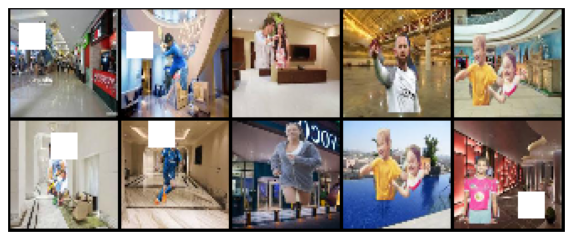

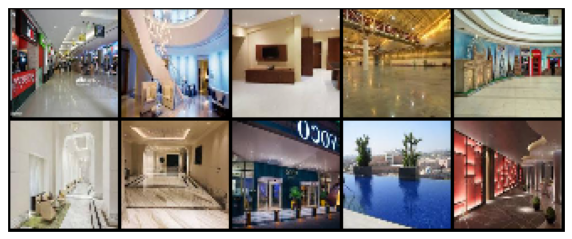

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


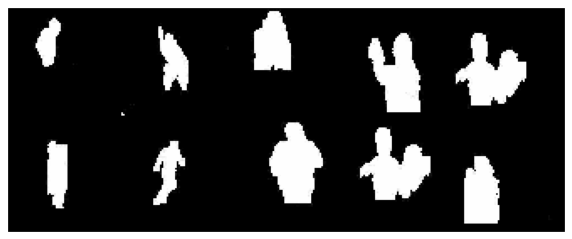

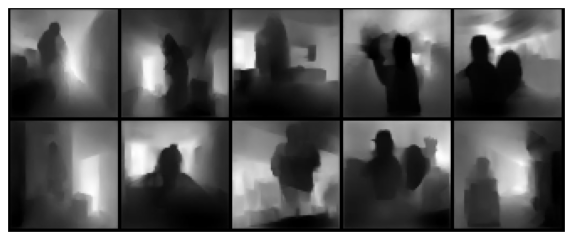

In [25]:
### Combination 1 : Normalized image with normalized show function (Should work fine)
norm_show(imgs_norm_fg_bg, fg_bg_mean, fg_bg_stdev, nrow=rows)
norm_show(imgs_norm_bg, bg_mean, bg_stdev, nrow=rows)
norm_show(imgs_norm_mask, mask_mean, mask_stdev, nrow=rows)
norm_show(imgs_norm_depth, depth_mean, depth_stdev, nrow=rows)

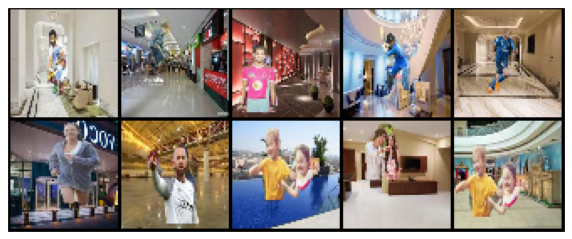

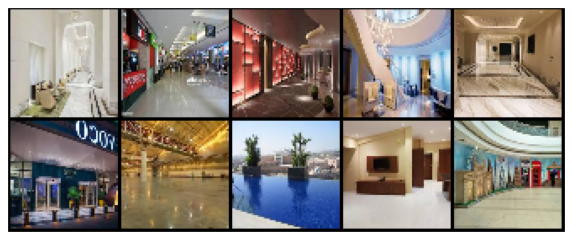

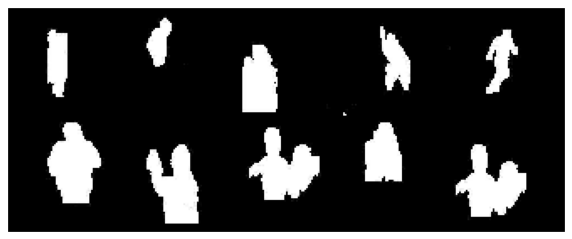

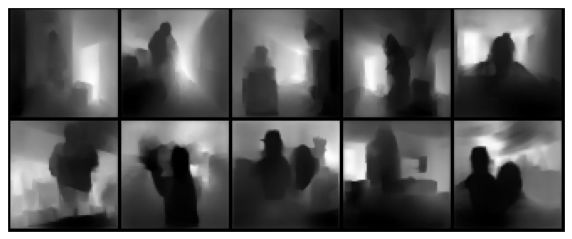

In [26]:
### Combination 2 : Un-Normalized image with Un-normalized show function (Should work fine)
no_norm_show(imgs_no_norm_fg_bg, nrow=rows)
no_norm_show(imgs_no_norm_bg, nrow=rows)
no_norm_show(imgs_no_norm_mask, nrow=rows)
no_norm_show(imgs_no_norm_depth, nrow=rows)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


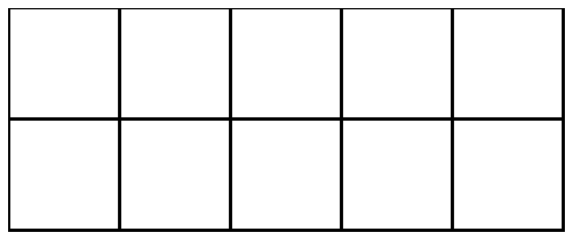

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


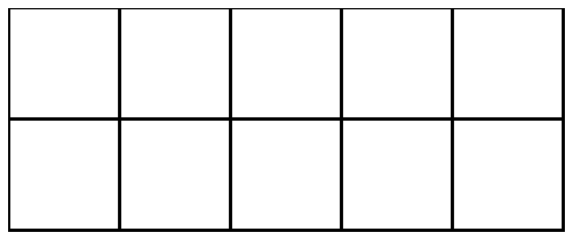

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


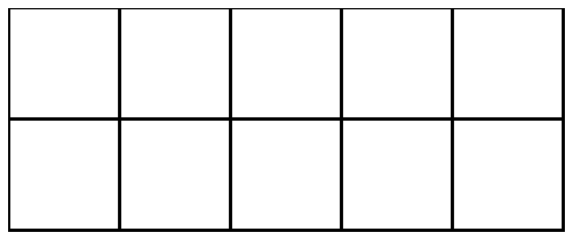

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


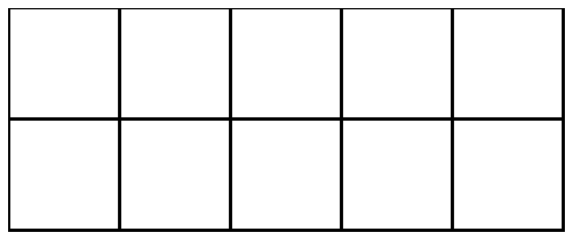

In [27]:
### Combination 3 : Un-Normalized image with normalized show function (Shouldn't display correctly)
norm_show(imgs_no_norm_fg_bg_dup, fg_bg_mean, fg_bg_stdev, nrow=rows)
norm_show(imgs_no_norm_bg_dup, bg_mean, bg_stdev, nrow=rows)
norm_show(imgs_no_norm_mask_dup, mask_mean, mask_stdev, nrow=rows)
norm_show(imgs_no_norm_depth_dup, depth_mean, depth_stdev, nrow=rows)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


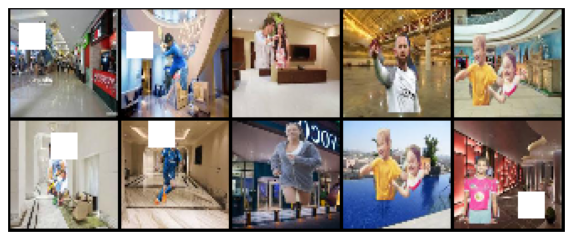

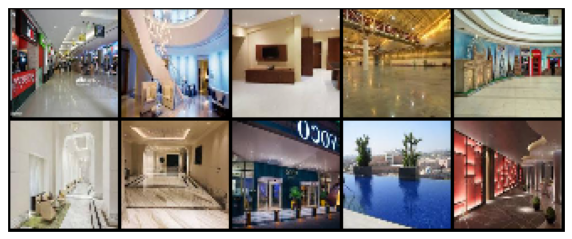

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


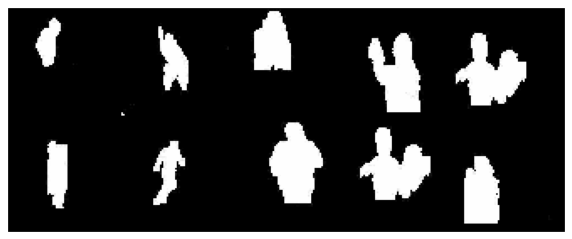

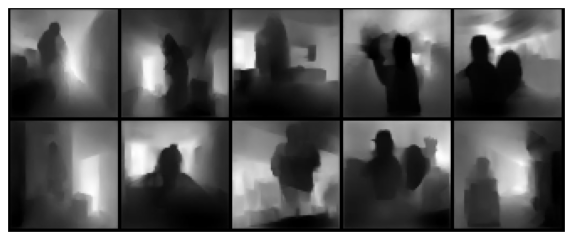

In [28]:
### Combination 4 : Normalized image with Un-normalized show function (Shouldn't display correctly)
no_norm_show(imgs_norm_fg_bg_dup, nrow=rows)
no_norm_show(imgs_norm_bg_dup, nrow=rows)
no_norm_show(imgs_norm_mask_dup, nrow=rows)
no_norm_show(imgs_norm_depth_dup, nrow=rows)

In [91]:
i=0
path = '/content/FG_BG_400K/'
for file_name in os.listdir('/content/FG_BG_400K/'):
    img = Image.open(f'{path}{file_name}')
    arr = np.array(img)
    i +=1
    if i >= 1:
      break
arr      

array([[[ 57,  51,  51],
        [ 59,  53,  53],
        [ 61,  55,  55],
        ...,
        [ 32, 105,  86],
        [ 10,  87,  67],
        [  0,  72,  51]],

       [[ 55,  49,  49],
        [ 57,  51,  51],
        [ 60,  54,  54],
        ...,
        [ 48, 115,  98],
        [ 40, 111,  93],
        [ 27, 100,  81]],

       [[ 57,  51,  51],
        [ 58,  52,  52],
        [ 59,  53,  53],
        ...,
        [ 22,  78,  65],
        [ 39, 100,  85],
        [ 51, 113,  98]],

       ...,

       [[ 10,  16,  28],
        [  8,  14,  26],
        [  8,  14,  26],
        ...,
        [ 12,  22,  34],
        [ 12,  22,  34],
        [ 12,  22,  34]],

       [[ 45,  44,  58],
        [ 45,  44,  58],
        [ 47,  45,  59],
        ...,
        [ 12,  22,  34],
        [ 12,  22,  34],
        [ 12,  22,  34]],

       [[ 56,  52,  67],
        [ 54,  50,  65],
        [ 52,  48,  63],
        ...,
        [ 12,  22,  34],
        [ 12,  22,  34],
        [ 12,  22,  34]]

### Initializing the model and assigning it to Cuda

In [0]:
model = ntwk.FGDepth()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)

FGDepth(
  (convA): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convB): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (convC): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convD): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (convE): Sequential(
    (0): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (blck1): DownSize(
  

### Defining Freeze class. We are using transfer learning & hence this class will be used to freeze the layers as required.

In [0]:
freezer = Freeze.Freezer()

### Defining Loss Criterion & creating scheduler

In [0]:
#criterion  = nn.BCEWithLogitsLoss()
criterion1  = DiceLoss()
kernel_size = 3
criterion2  = SSIM(kernel_size, reduction = 'mean')

optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9, weight_decay = 1e-5)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optim, step_size=2, gamma=0.1)

### Defining train & test loss classes

In [0]:
train_loss_fn = Train.Training_loss()
test_loss_fn  = Test.Testing_loss()

### Reloading model from last saved weights that are present in gdrive

In [0]:
path = f'/content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
path_name       = '/content/gdrive/My Drive/plots_0528_Test/'
path_model_save = f'/content/gdrive/My Drive/FG_Depth_Prediction_0528V16A.pt'

file_name  = 'train_log.txt'
log_file    = open(f'{path_name}{file_name}','w')
log_file.close()
file_name  = 'test_log.txt'
log_file   = open(f'{path_name}{file_name}','w') 
log_file.close()    

### Train & Test the model

In [0]:
train_loss_all, train_mask_loss_all, train_depth_loss_all, train_mask_iou_all, train_depth_iou_all = [], [], [], [], []
test_loss_all,  test_mask_loss_all,  test_depth_loss_all,  test_mask_iou_all,  test_depth_iou_all  = [], [], [], [], []

for epoch in range(1,2):
  train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = 0, 0, 0, 0, 0
  test_loss,  test_mask_loss,  test_depth_loss,  test_mask_iou,  test_depth_iou  = 0, 0, 0, 0, 0
  if epoch < 2:
     batch_size, loader = bs, train_dl_b1
     freezer.freeze_mask_layers(model)
  elif epoch < 3:
     batch_size, loader  = bs, train_dl_b2
     freezer.freeze_mask_layers(model)    
  elif epoch < 4:
     batch_size, loader = bs, train_dl_b3
     freezer.freeze_mask_layers(model)  
  elif epoch < 5:
     batch_size, loader  = bs_small, train_dl_b4
     freezer.freeze_mask_layers(model)  
  elif epoch < 6:
     batch_size, loader  = bs_large, train_dl_b5
     freezer.freeze_mask_layers(model)
  elif epoch < 7:
     batch_size, loader = bs,  train_dl_b1
     freezer.freeze_depth_layers(model)
  elif epoch < 8:
     batch_size, loader  = bs, train_dl_b2
     freezer.freeze_depth_layers(model) 
  elif epoch < 9:
     batch_size, loader  = bs, train_dl_b3
     freezer.freeze_depth_layers(model)  
  elif epoch < 10:
     batch_size, loader = bs_small, train_dl_b4
     freezer.freeze_depth_layers(model)  
  elif epoch < 11:
     batch_size, loader = bs_large, train_dl_b5
     freezer.freeze_depth_layers(model)      

  train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc( \
                                                           model, model.device, loader,\
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  batch_size, loader = bs, test_dl
  test_loss, test_mask_loss, test_depth_loss, test_mask_iou, test_depth_iou = test_loss_fn.test_loss_calc(             \
                                                         model, model.device, loader, optim,                           \
                                                         epoch, criterion1, criterion2, batch_size, path_name,         \
                                                         scheduler, img_save)
  scheduler.step()

  train_loss_all.append(train_loss.item()), train_mask_loss_all.append(train_mask_loss.item()), train_depth_loss_all.append(train_depth_loss.item())
  test_loss_all.append(test_loss.item()),   test_mask_loss_all.append(test_mask_loss.item()),   test_depth_loss_all.append(test_depth_loss.item())
  train_mask_iou_all.append(train_mask_iou), train_depth_iou_all.append(train_depth_iou)
  test_mask_iou_all.append(test_mask_iou),   test_depth_iou_all.append(test_depth_iou)

  gc.collect()

In [0]:
print('train_loss_all:',train_loss_all)
print('train_mask_loss_all:',train_mask_loss_all)
print('train_depth_loss_all:',train_depth_loss_all)
print('train_mask_iou_all:',train_mask_iou_all)
print('train_depth_iou_all:',train_depth_iou_all)
print('test_loss_all:',test_loss_all)
print('test_mask_loss_all:',test_mask_loss_all)
print('test_depth_loss_all:',test_depth_loss_all)
print('test_mask_iou_all:',test_mask_iou_all)
print('test_depth_iou_all:',test_depth_iou_all)

In [0]:
 
figure = plt.figure(figsize=(25,5))

plt.subplot(1,5,1)
plt.title("Loss Plot")
plt.plot(train_loss_all,label='Train Loss')
plt.plot(test_loss_all, label='Test Loss')
plt.legend(loc="best")

plt.subplot(1,5,2)
plt.title("Mask Losses")
plt.plot(train_mask_loss_all,label='Train Mask Loss')
plt.plot(test_mask_loss_all, label='Test Mask Loss')
plt.legend(loc="best")

plt.subplot(1,5,3)
plt.title("Depth Losses")
plt.plot(train_depth_loss_all,label='Train Depth Loss')
plt.plot(test_depth_loss_all, label='Test Depth Loss')
plt.legend(loc="best")

plt.subplot(1,5,4)
plt.title("Mask IOU")
plt.plot(train_mask_iou_all,label='Train Mask IOU')
plt.plot(test_mask_iou_all, label='Test Mask IOU')
plt.legend(loc="best")

plt.subplot(1,5,5)
plt.title("Depth IOU")
plt.plot(train_depth_iou_all,label='Train Depth IOU')
plt.plot(test_depth_iou_all, label='Test Depth IOU')
plt.legend(loc="best")

In [0]:
tensor = torch.tensor((),dtype=torch.float64)
tensor.new_ones((4,3,2,2))

In [55]:
lst = []
for i in range(1,5):
 for j in range(1,13):
   if j < 5:
      lst.append(i)
   elif j < 9:
      lst.append(i*5)
   elif j < 13:
      lst.append(i*7)         
tensor = torch.tensor(lst,dtype=torch.float32) 
tensor = tensor.view(4,3,2,2)
tensor  

tensor([[[[ 1.,  1.],
          [ 1.,  1.]],

         [[ 5.,  5.],
          [ 5.,  5.]],

         [[ 7.,  7.],
          [ 7.,  7.]]],


        [[[ 2.,  2.],
          [ 2.,  2.]],

         [[10., 10.],
          [10., 10.]],

         [[14., 14.],
          [14., 14.]]],


        [[[ 3.,  3.],
          [ 3.,  3.]],

         [[15., 15.],
          [15., 15.]],

         [[21., 21.],
          [21., 21.]]],


        [[[ 4.,  4.],
          [ 4.,  4.]],

         [[20., 20.],
          [20., 20.]],

         [[28., 28.],
          [28., 28.]]]])

In [49]:
n, s, sq = 0, 0, 0
for i in range(tensor.shape[0]):
    x = np.array(tensor[i])/255
    s += x.sum(axis=(1,2))
    sq += np.sum(np.square(x),axis=(1,2))
    n += x.shape[1]*x.shape[2]
mu = s/n
std =np.sqrt((sq/n - np.square(mu)))
print(mu,sq/n,std,n)

[0.00980392 0.04901961 0.06862745] [0.00011534 0.00288351 0.00565167] [0.00438445 0.02192223 0.03069112] 16


In [33]:
tensor[0].shape

torch.Size([3, 2, 2])

In [0]:
mean, stdev = [0.00980392, 0.04901961, 0.06862745], [0.00438445, 0.02192223, 0.03069112]

In [57]:
tensor = tensor/255
tensor

tensor([[[[0.0039, 0.0039],
          [0.0039, 0.0039]],

         [[0.0196, 0.0196],
          [0.0196, 0.0196]],

         [[0.0275, 0.0275],
          [0.0275, 0.0275]]],


        [[[0.0078, 0.0078],
          [0.0078, 0.0078]],

         [[0.0392, 0.0392],
          [0.0392, 0.0392]],

         [[0.0549, 0.0549],
          [0.0549, 0.0549]]],


        [[[0.0118, 0.0118],
          [0.0118, 0.0118]],

         [[0.0588, 0.0588],
          [0.0588, 0.0588]],

         [[0.0824, 0.0824],
          [0.0824, 0.0824]]],


        [[[0.0157, 0.0157],
          [0.0157, 0.0157]],

         [[0.0784, 0.0784],
          [0.0784, 0.0784]],

         [[0.1098, 0.1098],
          [0.1098, 0.1098]]]])

In [0]:
  for i in range(tensor.shape[0]):
    for j in range(0,3):  
        tensor[i,j] = (tensor[i,j] - mean[j]) / stdev[j] 

In [59]:
tensor

tensor([[[[-1.3416, -1.3416],
          [-1.3416, -1.3416]],

         [[-1.3416, -1.3416],
          [-1.3416, -1.3416]],

         [[-1.3416, -1.3416],
          [-1.3416, -1.3416]]],


        [[[-0.4472, -0.4472],
          [-0.4472, -0.4472]],

         [[-0.4472, -0.4472],
          [-0.4472, -0.4472]],

         [[-0.4472, -0.4472],
          [-0.4472, -0.4472]]],


        [[[ 0.4472,  0.4472],
          [ 0.4472,  0.4472]],

         [[ 0.4472,  0.4472],
          [ 0.4472,  0.4472]],

         [[ 0.4472,  0.4472],
          [ 0.4472,  0.4472]]],


        [[[ 1.3416,  1.3416],
          [ 1.3416,  1.3416]],

         [[ 1.3416,  1.3416],
          [ 1.3416,  1.3416]],

         [[ 1.3416,  1.3416],
          [ 1.3416,  1.3416]]]])

In [0]:
  for i in range(tensor.shape[0]):
    for j in range(0,3):  
        tensor[i,j] = ((tensor[i,j] * stdev[j]) + mean[j])*255

In [61]:
tensor

tensor([[[[ 1.0000,  1.0000],
          [ 1.0000,  1.0000]],

         [[ 5.0000,  5.0000],
          [ 5.0000,  5.0000]],

         [[ 7.0000,  7.0000],
          [ 7.0000,  7.0000]]],


        [[[ 2.0000,  2.0000],
          [ 2.0000,  2.0000]],

         [[10.0000, 10.0000],
          [10.0000, 10.0000]],

         [[14.0000, 14.0000],
          [14.0000, 14.0000]]],


        [[[ 3.0000,  3.0000],
          [ 3.0000,  3.0000]],

         [[15.0000, 15.0000],
          [15.0000, 15.0000]],

         [[21.0000, 21.0000],
          [21.0000, 21.0000]]],


        [[[ 4.0000,  4.0000],
          [ 4.0000,  4.0000]],

         [[20.0000, 20.0000],
          [20.0000, 20.0000]],

         [[28.0000, 28.0000],
          [28.0000, 28.0000]]]])

In [0]:
tensor = torch.tensor((tensor),dtype=torch.int32)

In [29]:
tensor

tensor([[[[   11,    11],
          [   11,    11]],

         [[  511,   511],
          [  511,   511]],

         [[ 7111,  7111],
          [ 7111,  7111]]],


        [[[   21,    21],
          [   21,    21]],

         [[ 1011,  1011],
          [ 1011,  1011]],

         [[14111, 14111],
          [14111, 14111]]],


        [[[   31,    31],
          [   31,    31]],

         [[ 1511,  1511],
          [ 1511,  1511]],

         [[21111, 21111],
          [21111, 21111]]],


        [[[   41,    41],
          [   41,    41]],

         [[ 2011,  2011],
          [ 2011,  2011]],

         [[28111, 28111],
          [28111, 28111]]]], dtype=torch.int32)